# Models Comparison for TinyML

In [158]:
# Load libraries
import numpy as np
from numpy import arange
import pickle
from pandas import read_csv
#
import matplotlib.pyplot as plt

#
import pandas as pd
from pandas import read_csv

from sklearn.metrics import confusion_matrix,  classification_report, f1_score
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline

from keras.models import Sequential, Model 
from keras.layers import Dense, Input, concatenate, Activation, Dropout
from keras.optimizers import Adam
from tensorflow.keras import layers

import tensorflow
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from micromlgen import port
import tinymlgen as tiny

import warnings
import seaborn as sbs
import sys

warnings.filterwarnings('ignore')

In [159]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tensorflow.random.set_seed(RANDOM_SEED)
np.set_printoptions(threshold=sys.maxsize)

In [160]:
data = ['../data/X-intensity.pkl', '../data/X-all.pkl', '../data/X-10-25.pkl', '../data/X-1-2.pkl', '../data/X-25_50-50_25.pkl']
labels = ['../data/y-intensity.pkl', '../data/y-all.pkl', '../data/y-10-25.pkl', '../data/y-1-2.pkl', '../data/y-25_50-50_25.pkl']
choosenIndex = 1
tasks = ['intensity', 'all','10-25','1-2', '25-50']
with open(data[choosenIndex], 'rb') as f:
    X = pickle.load(f)

with open(labels[choosenIndex], 'rb') as f:
    y = pickle.load(f)

In [161]:
if choosenIndex == 1:
    X = X[165:-13]
    y = y[165:-13]
if choosenIndex == 2:
    X = X[146:-13]
    y = y[146:-13]
if choosenIndex == 3:
    X = X[101:-13]
    y = y[101:-13]

In [162]:
print(X.shape)

(8329, 60)


In [163]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)
uniques = np.unique(y)

In [164]:
print(X_test.shape)
print(X_test)

(1666, 60)
[[ 0.03  0.02  0.99 -0.03 -0.01  0.96 -0.   -0.01  0.96  0.05  0.01  1.
   0.02  0.03  1.03 -0.01 -0.02  0.96  0.02  0.    0.98  0.02  0.01  0.98
   0.04 -0.02  0.92  0.07  0.02  1.01  0.08  0.02  0.97 -0.03 -0.01  0.97
   0.08 -0.    0.9   0.04  0.02  1.01  0.02  0.01  0.98  0.02  0.01  0.99
   0.09  0.01  0.94  0.08  0.01  0.96  0.02  0.01  1.01  0.1   0.03  0.99]
 [ 0.03  0.11  0.97  0.02  0.11  1.    0.01  0.09  1.01  0.02  0.08  1.04
  -0.04  0.06  0.98 -0.04  0.11  0.94 -0.    0.11  1.02 -0.08  0.04  0.99
  -0.03  0.07  0.98  0.05  0.15  0.99 -0.    0.09  1.01  0.04  0.13  1.03
  -0.03  0.07  0.99 -0.07  0.05  0.96  0.    0.08  0.96  0.03  0.14  0.96
   0.03  0.12  0.96  0.02  0.06  1.01 -0.02  0.09  0.98  0.01  0.13  0.99]
 [-0.03  0.02  0.98 -0.05  0.03  0.98 -0.03  0.03  0.98 -0.05  0.02  0.98
  -0.03  0.04  0.98 -0.04  0.02  0.98 -0.04  0.04  0.99 -0.04  0.01  0.98
  -0.05  0.04  0.98 -0.04  0.01  0.98 -0.05  0.04  0.98 -0.03  0.01  0.98
  -0.05  0.04  0.98 -0.03  

## Model Spotting

In [165]:
# Test options and evaluation metric
num_folds = 10
seed = 42
scoring = 'f1_macro'


In [166]:
# Spot-Check Algorithms
models = []

#models.append(('XGB', XGBClassifier(random_state=seed)))
models.append(('GNB', GaussianNB(var_smoothing=2e-9)))
models.append(('LR',  LogisticRegression(random_state=seed)))
models.append(('CART' , DecisionTreeClassifier(random_state=seed)))
models.append(('SVC' , SVC(gamma=0.5, random_state=seed)))
models.append(('RF', RandomForestClassifier(random_state=seed, n_estimators = 50)))


In [167]:
results = []
names = []
for name, model in models:
    # Dividere dati in n = num_folds
    kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = np.array([])
    for train_idx, test_idx, in kf.split(X_train, y_train):
        X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
        X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
        model.fit(X_cross_train, y_cross_train)  
        y_pred = model.predict(X_cross_test)
        f1s = f1_score(y_cross_test, y_pred, average="weighted")
        cv_results = np.append(cv_results, [f1s])
    results.append(cv_results)
    names.append(name)
    #msg = "%s - %f - %f" % (name, cv_results.mean(), cv_results.std())
    msg = "{} - {:.2f} {:.2f}".format(name, cv_results.mean(), cv_results.std()).replace('.', ',')
    print(msg)

GNB - 1,00 0,00
LR - 0,93 0,01
CART - 0,97 0,01
SVC - 0,99 0,00
RF - 1,00 0,00


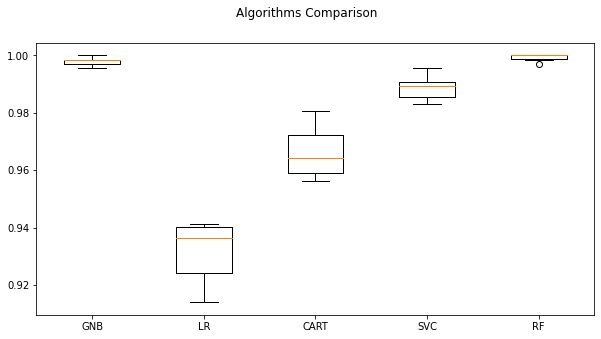

In [168]:
# Compare Algorithms
fig = plt.figure(figsize=(10,5))
fig.suptitle('Algorithms Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Valutazione dei modelli sul Test Set

In [169]:

def classification_report_csv(report, model_name):
    report_data = []
    lines = report.split('\n')
    index = 0
    row = lines[-4].split('    ')
    accuracy = row[-2]
    for line in lines[2:-5]:
        row = {}
        row_data = line.split('      ')
        row['class'] = uniques[index]
        row['precision'] = float(row_data[2]) 
        row['recall'] = float(row_data[3]) 
        row['f1_score'] = float(row_data[4])
        row['accuracy'] = accuracy
        report_data.append(row)
        index += 1
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe.to_csv(tasks[choosenIndex]+ '/classificationReports'+ '/'+'classification_report' + model_name +  '.csv', index = False)
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)

for name, model in models:
    model.fit(X_train,  y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print(f"Model {name}: ")
    report = classification_report(y_test, pred_test)
    print(report)
    classification_report_csv(report, name)
    print("-------------------------------------------------------------")

Model GNB: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       241
           1       1.00      1.00      1.00       282
           2       1.00      1.00      1.00       213
           3       1.00      1.00      1.00       291
           4       1.00      1.00      1.00       282
           5       1.00      1.00      1.00       357

    accuracy                           1.00      1666
   macro avg       1.00      1.00      1.00      1666
weighted avg       1.00      1.00      1.00      1666

-------------------------------------------------------------
Model LR: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       241
           1       0.87      1.00      0.93       282
           2       1.00      0.59      0.74       213
           3       1.00      1.00      1.00       291
           4       0.85      1.00      0.92       282
           5       1.00      1.00      1.00    

# Valutazione Inferance Rate medio (|X_test| = 100)

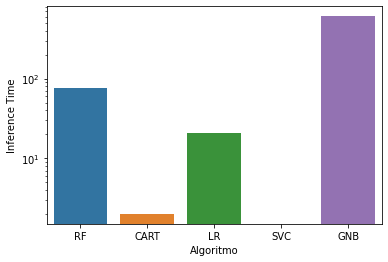

In [170]:
csv = read_csv("InfTimeReport.csv")
g = sbs.barplot(x=csv['Algoritmo'], y=csv['InfTime'])
g.set_yscale("log")
plt.ylabel("Inference Time")
plt.show()

# Memoria occupata

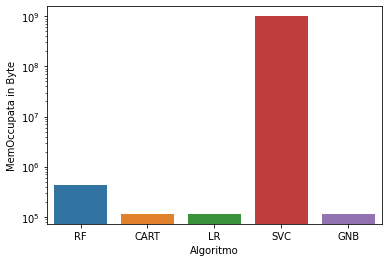

In [146]:
csv = read_csv("MemOccupationReport.csv")
g = sbs.barplot(x=csv['Algoritmo'], y=csv['MemOccupata'])
g.set_yscale('log')
plt.ylabel("MemOccupata in Byte")
plt.show()
# SVC in overlow

# Neural Network

In [171]:
def getNetwork():
    n = 50
    model = Sequential(name="Sequential-NN")
    model.add(layers.Dense(X.shape[1], activation='relu', input_shape=(X.shape[1],)))
    model.add(layers.Dense(np.unique(y).size * n, activation='relu'))
    model.add(layers.Dense(np.unique(y).size, activation='softmax'))
    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

# Cross-Validation NN

In [34]:
EPOCHS = 500
BATCH_SIZE = 8
num_folds = 10

kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
cv_results = np.array([])
for train_idx, test_idx, in kf.split(X_train, y_train):
    X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
    X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
    model = getNetwork()
    model.fit(X_cross_train, y_cross_train, epochs=EPOCHS, batch_size=BATCH_SIZE)  
    y_pred = model.predict(X_cross_test)
    predictions_categorical = np.argmax(y_pred, axis=1)
    f1s = f1_score(y_cross_test, predictions_categorical, average="weighted")
    cv_results = np.append(cv_results, [f1s])

print(f'Average score of Cross Validation: {cv_results.mean()}')

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 60)                3660      
_________________________________________________________________
dense_4 (Dense)              (None, 250)               15250     
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 1255      
Total params: 20,165
Trainable params: 20,165
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
351/351 [==============================] - 0s 544us/step - loss: 1.6039 - accuracy: 0.2164
Epoch 2/500
351/351 [==============================] - 0s 549us/step - loss: 1.5700 - accuracy: 0.3251
Epoch 3/500
351/351 [==============================] - 0s 554us/step - loss: 1.5246 - accuracy: 0.3939
Epoch 4/500
351/351 [==============================] - 0s 583us/step -

KeyboardInterrupt: 

# Train and Test

In [174]:
EPOCHS = 100 if choosenIndex < 2 else 500
BATCH_SIZE = 10

model = getNetwork()
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.25)
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)
report = classification_report(y_test, pred)
classification_report_csv(report, "NN")
print(report)

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 60)                3660      
_________________________________________________________________
dense_37 (Dense)             (None, 300)               18300     
_________________________________________________________________
dense_38 (Dense)             (None, 6)                 1806      
Total params: 23,766
Trainable params: 23,766
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
500/500 [==============================] - 0s 810us/step - loss: 1.6702 - accuracy: 0.3916 - val_loss: 1.4755 - val_accuracy: 0.5672
Epoch 2/100
500/500 [==============================] - 0s 705us/step - loss: 1.1903 - accuracy: 0.6270 - val_loss: 0.9119 - val_accuracy: 0.7095
Epoch 3/100
500/500 [==============================] - 0s 702us/step - loss: 0.7433 - acc

500/500 [==============================] - 0s 790us/step - loss: 0.0172 - accuracy: 0.9932 - val_loss: 0.0135 - val_accuracy: 0.9946
Epoch 53/100
500/500 [==============================] - 0s 782us/step - loss: 0.0187 - accuracy: 0.9928 - val_loss: 0.0142 - val_accuracy: 0.9952
Epoch 54/100
500/500 [==============================] - 0s 782us/step - loss: 0.0176 - accuracy: 0.9940 - val_loss: 0.0139 - val_accuracy: 0.9952
Epoch 55/100
500/500 [==============================] - 0s 819us/step - loss: 0.0185 - accuracy: 0.9930 - val_loss: 0.0160 - val_accuracy: 0.9952
Epoch 56/100
500/500 [==============================] - 0s 778us/step - loss: 0.0183 - accuracy: 0.9940 - val_loss: 0.0137 - val_accuracy: 0.9952
Epoch 57/100
500/500 [==============================] - 0s 755us/step - loss: 0.0181 - accuracy: 0.9938 - val_loss: 0.0131 - val_accuracy: 0.9946
Epoch 58/100
500/500 [==============================] - 0s 743us/step - loss: 0.0182 - accuracy: 0.9940 - val_loss: 0.0132 - val_accuracy

# Export Models in C code

In [175]:
# Neural network with TinyMLGen
with open(tasks[choosenIndex] + '/exportedModels/NNmodel.h', 'w') as f:
    f.write(tiny.port(model, optimize=False))

# Classifiers with MicroMLGen
for name, model in models:
    prepath = tasks[choosenIndex] + '/exportedModels/'
    path = prepath + name + '.h'
    with open(path, 'w') as f:
        f.write(port(model, optimize=False))

INFO:tensorflow:Assets written to: /tmp/tmp4q8i6cum/assets


INFO:tensorflow:Assets written to: /tmp/tmp4q8i6cum/assets
